In [4]:
import json, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import Model
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Concatenate
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input
import tensorflow as tf
from tensorflow.keras import optimizers
from sklearn.utils import class_weight

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset=pd.DataFrame()
dataset = pd.read_pickle('/content/drive/MyDrive/dataset_prepro.pickle')
# dataset = pd.read_pickle('/content/drive/MyDrive/dataset_original.pickle')

In [8]:
label_list = [ "Electricity",
        "Storm",
        "WaterDamage",
        "Other_DamageType",
        "CracksAndTears",
        "GlassBreakage",
        "Collision",
        "Burglary",
        "Fire_Smoke_Explosion",
        "Theft",
        "Environment_OilFuel",
        "Flooding",]
dataset = dataset[dataset["labels.damage_type"].isin(label_list)]

In [9]:
dataset['labels.damage_type'].unique()

array(['WaterDamage', 'CracksAndTears', 'Other_DamageType',
       'GlassBreakage', 'Storm', 'Electricity', 'Burglary', 'Theft',
       'Collision', 'Fire_Smoke_Explosion', 'Flooding',
       'Environment_OilFuel'], dtype=object)

In [10]:
dataset.to_pickle('/content/drive/MyDrive/dataset_prepro_lbl12.pickle')

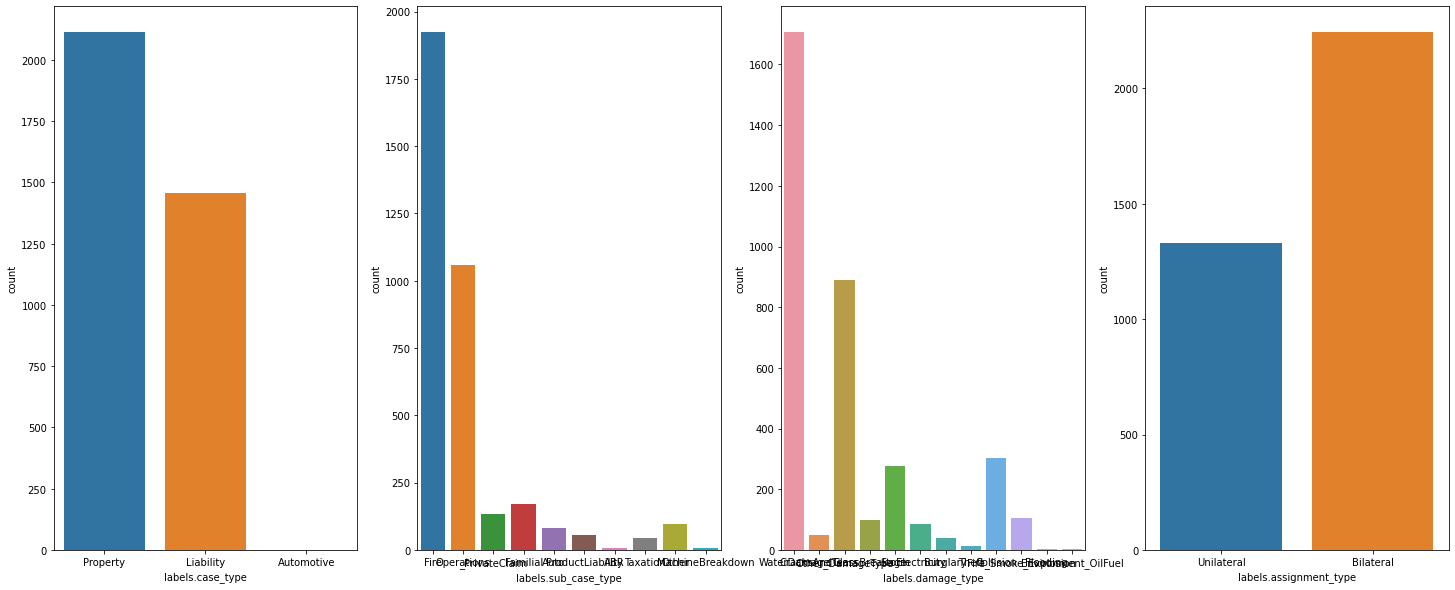

In [11]:
fig, ax = plt.subplots(1,4)
fig.set_figwidth(25)
fig.set_figheight(10)
sns.countplot(x='labels.case_type',data=dataset,ax=ax[0])
sns.countplot(x='labels.sub_case_type',data=dataset,ax=ax[1])
sns.countplot(x='labels.damage_type',data=dataset,ax=ax[2])
sns.countplot(x='labels.assignment_type',data=dataset,ax=ax[3])

In [12]:
y=dataset[['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type']]
X=dataset.drop(['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type'], axis=1)

In [13]:
X=X.drop(['language'],axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=0)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(2858, 3) (2858, 4)
(715, 3) (715, 4)


In [15]:
X_train

,mail_content,attachments_filename,attachments_content
535,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT,nv koning bic btw verzekeringsmaatschappij to...
2484,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT Bestandenblad Nieuwe schad...,nv koning bic btw verzekeringsmaatschappij to...
182,sans mevrouw contacteren verzekeraar bijlage ...,aangiftebestekfoto's polis ingebrek stel kbc V...,sent wed dec subject onze ref message schade ...
1568,annexe transmettons document concernant missi...,MISSION_ASSIGNEMENT Mail aé FORMULAIRE TVA + c...,blvd roi ii bic tva rpm entreprise agr nation...
1434,bijlage wij document betrekking opdracht toev...,photo photo dommage devis #1 photo MISSION_A...,rue ile sainte tva anderlecht enregistrement ...
...,...,...,...
847,annexe transmettons document concernant missi...,MISSION_ASSIGNEMENT devis plafond 1 etage déc...,blvd roi ii bic tva rpm entreprise agr nation...
3353,bijlage wij document betrekking opdracht toev...,2020-04472- H ZSN202012188 MISSION_ASSIGNEMENT...,beheer schade date december subject geachte w...
1679,bijlage wij document betrekking opdracht toev...,RE TUYPENS MONIQUE - schade 13.11.2020 -o. re...,hanssens date november beheer schade subject ...
2671,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT foto1 mail van de agt kla...,nv koning bic btw verzekeringsmaatschappij to...


In [16]:
#Aantal rows waar content meer dan 500 woorden is
X[~(X.attachments_content.str.split().str.len() > 500)]

,mail_content,attachments_filename,attachments_content
0,annexe transmettons document concernant missi...,MISSION_ASSIGNEMENT,blvd roi ii bic tva rpm entreprise agr nation...
2,sans mevrouw contacteren verzekeraar bijlage ...,Polis 1213534_12-29-2020_0240361364 VIVIUM PR ...,historiek num contract ris schade num beschri...
8,sans mevrouw contacteren verzekeraar bijlage ...,FNOL Snapshot IN via agt oa bestekken VIVIUM ...,samenvatting aangifte datum pagina aangifte r...
10,sans mevrouw contacteren verzekeraar bijlage ...,VIVIUM GL C302100090 C36 Inspectie - MS 2021-0...,materiele schade zetel expert experts dossier...
12,sans mevrouw contacteren verzekeraar bijlage ...,via agt oauitnodiging exp FNOL Snapshot IN VI...,sent tue jan subject klant onze ref expert tp...
...,...,...,...
3653,annexe transmettons document concernant missi...,MISSION_ASSIGNEMENT in mail décla rapport de ...,blvd roi ii bic tva rpm entreprise agr nation...
3657,annexe transmettons document concernant missi...,MISSION_ASSIGNEMENT cause photo photo in mail...,blvd roi ii bic tva rpm entreprise agr nation...
3659,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT storm 11 03 bestek aangifte,nv koning bic btw verzekeringsmaatschappij to...
3661,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT in ontvangstmelding verze...,nv koning bic btw verzekeringsmaatschappij to...


In [17]:
dataset.attachments_filename.str.split().str.len().max()

366

In [18]:
dataset.mail_content.str.split().str.len().max()

148

In [19]:
dataset.attachments_content.str.split().str.len().max()

31044

In [20]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each mail.
# MAX_SEQUENCE_LENGTH = 5000
# This is fixed.
EMBEDDING_DIM = 100

In [21]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['mail_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_mc = tokenizer.texts_to_sequences(X_train['mail_content'].values)
X_train_mc = pad_sequences(X_train_mc,maxlen=400)
print('Shape of data X_train_mc:', X_train_mc.shape)

X_test_mc = tokenizer.texts_to_sequences(X_test['mail_content'].values)
X_test_mc = pad_sequences(X_test_mc,maxlen=400)
print('Shape of data X_train_mc:', X_test_mc.shape)

Found 561 unique tokens.
Shape of data X_train_mc: (2858, 400)
Shape of data X_train_mc: (715, 400)


In [22]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_filename'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_af = tokenizer.texts_to_sequences(X_train['attachments_filename'].values)
X_train_af = pad_sequences(X_train_af,maxlen=200)
print('Shape of data X_train_af:', X_train_af.shape)

X_test_af = tokenizer.texts_to_sequences(X_test['attachments_filename'].values)
X_test_af = pad_sequences(X_test_af,maxlen=200)
print('Shape of data X_test_af:', X_test_af.shape)

Found 15566 unique tokens.
Shape of data X_train_af: (2858, 200)
Shape of data X_test_af: (715, 200)


In [23]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_ac = tokenizer.texts_to_sequences(X_train['attachments_content'].values)
X_train_ac = pad_sequences(X_train_ac,maxlen=500)
print('Shape of data X_train_ac:', X_train_ac.shape)

X_test_ac = tokenizer.texts_to_sequences(X_test['attachments_content'].values)
X_test_ac = pad_sequences(X_test_ac,maxlen=500)
print('Shape of data X_train_ac:', X_test_ac.shape)

Found 43261 unique tokens.
Shape of data X_train_ac: (2858, 500)
Shape of data X_train_ac: (715, 500)


In [24]:
#One-hot multi output
y1_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.assignment_type']]).columns)
y1_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.assignment_type']]).columns)
y2_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.case_type']]).columns)
y2_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.case_type']]).columns)
y3_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.sub_case_type']]).columns)
y3_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.sub_case_type']]).columns)
y4_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.damage_type']]).columns)
y4_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.damage_type']]).columns)
# y1_train=y1_train.merge(pd.get_dummies(y_train[['labels.assignment_type']]),how='outer').fillna(0)
y1_train=y1_train.combine_first(pd.get_dummies(y_train[['labels.assignment_type']])).fillna(0)
print('Shape of label tensor Y1 Train:', y1_train.shape)
y1_test=y1_test.combine_first(pd.get_dummies(y_test[['labels.assignment_type']])).fillna(0)
print('Shape of label tensor Y1 Test:', y1_test.shape)

y2_train=y2_train.combine_first(pd.get_dummies(y_train[['labels.case_type']])).fillna(0)
print('Shape of label tensor Y2 Train:', y2_train.shape)
y2_test=y2_test.combine_first(pd.get_dummies(y_test[['labels.case_type']])).fillna(0)
print('Shape of label tensor Y2 Test:', y2_test.shape)

y3_train=y3_train.combine_first(pd.get_dummies(y_train[['labels.sub_case_type']])).fillna(0)
print('Shape of label tensor Y3 Train:', y3_train.shape)
y3_test=y3_test.combine_first(pd.get_dummies(y_test[['labels.sub_case_type']])).fillna(0)
print('Shape of label tensor Y3 Test:', y3_test.shape)

y4_train=y4_train.combine_first(pd.get_dummies(y_train[['labels.damage_type']])).fillna(0)
print('Shape of label tensor Y4 Train:', y4_train.shape)
y4_test=y4_test.combine_first(pd.get_dummies(y_test[['labels.damage_type']])).fillna(0)
print('Shape of label tensor Y4 Test:', y4_test.shape)

Shape of label tensor Y1 Train: (2858, 2)
Shape of label tensor Y1 Test: (715, 2)
Shape of label tensor Y2 Train: (2858, 3)
Shape of label tensor Y2 Test: (715, 3)
Shape of label tensor Y3 Train: (2858, 10)
Shape of label tensor Y3 Test: (715, 10)
Shape of label tensor Y4 Train: (2858, 12)
Shape of label tensor Y4 Test: (715, 12)


In [25]:
#OP NL EN FR
#Optimizer
opt = tf.keras.optimizers.Adam(lr=0.0001)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)

#checkpoint
checkpoint_path='/content/drive/MyDrive/LSTM_bestmodel.h5'
mc=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)

#Model
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))

# model = Sequential()
embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)

s_mc=SpatialDropout1D(0.5)(embeding_mc)
o_mc=LSTM(24, dropout=0.5)(s_mc)
s_af=SpatialDropout1D(0.5)(embeding_af)
o_af=LSTM(24, dropout=0.5)(s_af)
s_ac=SpatialDropout1D(0.5)(embeding_ac)
o_ac=LSTM(24, dropout=0.5)(s_ac)

concat_layer = Concatenate()([o_mc, o_af,o_ac])

o1=Dense(2, activation='softmax',name='assignment_type')(concat_layer)
o2=Dense(3, activation='softmax',name='case_type')(concat_layer)
o3=Dense(10, activation='softmax',name='sub_case_type')(concat_layer)
o4=Dense(12, activation='softmax',name='damage_type')(concat_layer)


epochs = 200
batch_size = 64

model = Model(inputs=[input_mc,input_af,input_ac], outputs=[o1, o2, o3, o4])
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit([X_train_mc,X_train_af,X_train_ac],[y1_train,y2_train,y3_train,y4_train],epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[es,mc])

Epoch 1/200
41/41 [==============================] - 45s 222ms/step - loss: 6.5425 - assignment_type_loss: 0.6896 - case_type_loss: 1.0856 - sub_case_type_loss: 2.2907 - damage_type_loss: 2.4766 - assignment_type_accuracy: 0.5783 - case_type_accuracy: 0.4570 - sub_case_type_accuracy: 0.1655 - damage_type_accuracy: 0.1552 - val_loss: 6.4447 - val_assignment_type_loss: 0.6833 - val_case_type_loss: 1.0518 - val_sub_case_type_loss: 2.2503 - val_damage_type_loss: 2.4594 - val_assignment_type_accuracy: 0.7273 - val_case_type_accuracy: 0.7273 - val_sub_case_type_accuracy: 0.5944 - val_damage_type_accuracy: 0.4091
Epoch 2/200
41/41 [==============================] - 8s 187ms/step - loss: 6.4088 - assignment_type_loss: 0.6814 - case_type_loss: 1.0363 - sub_case_type_loss: 2.2364 - damage_type_loss: 2.4547 - assignment_type_accuracy: 0.6648 - case_type_accuracy: 0.6728 - sub_case_type_accuracy: 0.4943 - damage_type_accuracy: 0.3053 - val_loss: 6.2380 - val_assignment_type_loss: 0.6747 - val_case

In [27]:
score = model.evaluate(x=[X_test_mc,X_test_af,X_test_ac], y=[y1_test, y2_test, y3_test, y4_test], verbose=1)
print("Loss:", score[0])
print("Test Accuracy:", score[1])

23/23 [==============================] - 1s 26ms/step - loss: 2.6916 - assignment_type_loss: 0.4348 - case_type_loss: 0.2107 - sub_case_type_loss: 0.6992 - damage_type_loss: 1.3469 - assignment_type_accuracy: 0.7944 - case_type_accuracy: 0.9203 - sub_case_type_accuracy: 0.8154 - damage_type_accuracy: 0.5832
Loss: 2.6916167736053467
Test Accuracy: 0.4348149597644806


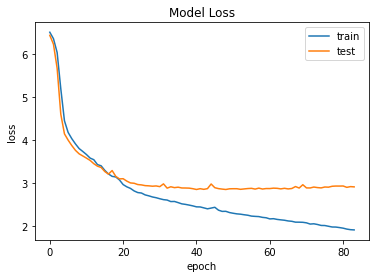

In [28]:
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.show()

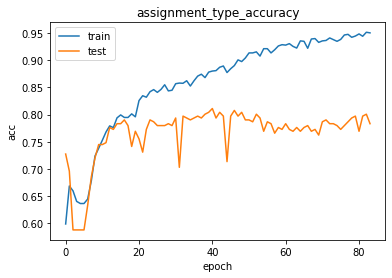

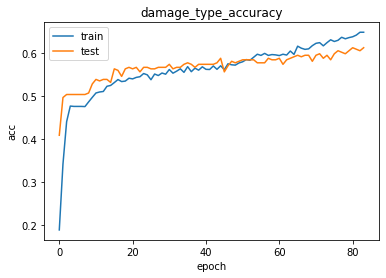

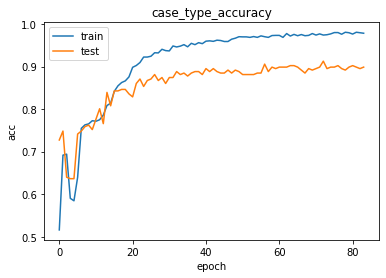

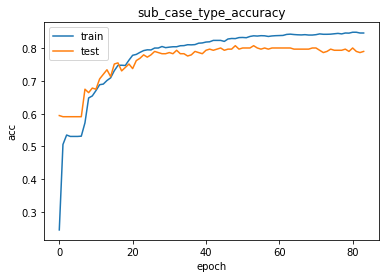

In [29]:
plt.title('assignment_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['assignment_type_accuracy'], label='train')
plt.plot(history.history['val_assignment_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('damage_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['damage_type_accuracy'], label='train')
plt.plot(history.history['val_damage_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('case_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['case_type_accuracy'], label='train')
plt.plot(history.history['val_case_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('sub_case_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['sub_case_type_accuracy'], label='train')
plt.plot(history.history['val_sub_case_type_accuracy'], label='test')
plt.legend()
plt.show();

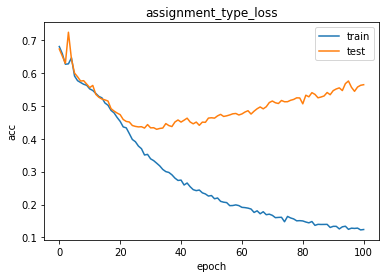

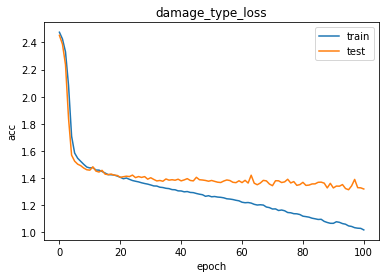

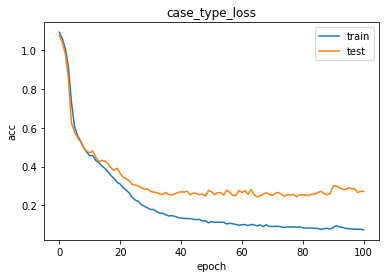

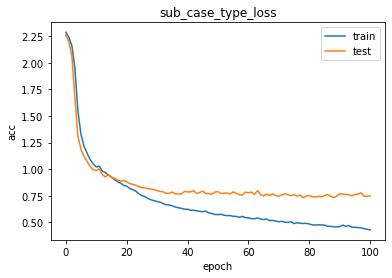

In [53]:
plt.title('assignment_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['assignment_type_loss'], label='train')
plt.plot(history.history['val_assignment_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('damage_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['damage_type_loss'], label='train')
plt.plot(history.history['val_damage_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('case_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['case_type_loss'], label='train')
plt.plot(history.history['val_case_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('sub_case_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['sub_case_type_loss'], label='train')
plt.plot(history.history['val_sub_case_type_loss'], label='test')
plt.legend()
plt.show();